In [1]:
%matplotlib inline

In [2]:
import hcipy as hci
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = (100, 60)
plt.rcParams['image.origin'] = True

## **Parameters**

In [4]:
wvlgth = 1e-6 #666e-9  

diam_aperture = 1.2           
focal_length = 18*diam_aperture 

diam_obs = 0.3/diam_aperture                                 # obscuration ratio
nb_spid = 4                                                  # [m]
spid_width = 0.05                                            # [m]

print('Fresnel number = {}'.format(diam_aperture**2/(wvlgth*focal_length)))

Fresnel number = 66666.66666666667


In [5]:
grid_size_pix = 1024
grid_diam = 1.5*diam_aperture

In [6]:
pupil_grid = hci.make_pupil_grid(grid_size_pix, grid_diam)

In [7]:
print('On pupil:{} m/pix'.format(pupil_grid.delta))  #same as grid_diam/grid_size_pix
print('This is not a real pixel ! This is for the computation')

On pupil:[0.00175953 0.00175953] m/pix
This is not a real pixel ! This is for the computation


## **Aperture Auxtel (spiders + central obscuration)**

In [8]:
central_obs = hci.aperture.make_obstructed_circular_aperture(diam_aperture, diam_obs)
spider_1 = hci.aperture.make_spider([0,0], [0.6,0.6], spid_width)         # [m][m]
spider_2 = hci.aperture.make_spider([0,0], [0.6,-0.6], spid_width)        # [m][m]
spider_3 = hci.aperture.make_spider([0,0], [-0.6,0.6], spid_width)        # [m][m]
spider_4 = hci.aperture.make_spider([0,0], [-0.6,-0.6], spid_width)       # [m][m]

tel_pupil = central_obs(pupil_grid)*spider_1(pupil_grid)*spider_2(pupil_grid)*spider_3(pupil_grid)*spider_4(pupil_grid)

hci.imshow_field(tel_pupil, cmap='gray')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Aperture')

## **Zernike**

In [9]:
fov = 8                                     # [λ/D], radius

F_nb = focal_length/diam_aperture
InPhase = 2*np.pi / wvlgth

sampl_focal = 8                             #échantillonage q (8samples per λ/D) 


In [10]:
wf = hci.Wavefront(tel_pupil, wvlgth)
    
focal_grid = hci.make_focal_grid(pupil_grid, sampl_focal, fov)
    
prop = hci.FraunhoferPropagator(pupil_grid, focal_grid, wvlgth, 10000*focal_length)
focal_image = prop.forward(wf)
    
int_map = focal_image.intensity.shaped 
psf_slice = int_map[:,int_map.shape[0]//2]

## **MULTIPLOOOOOT**

/home/novae/rey/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


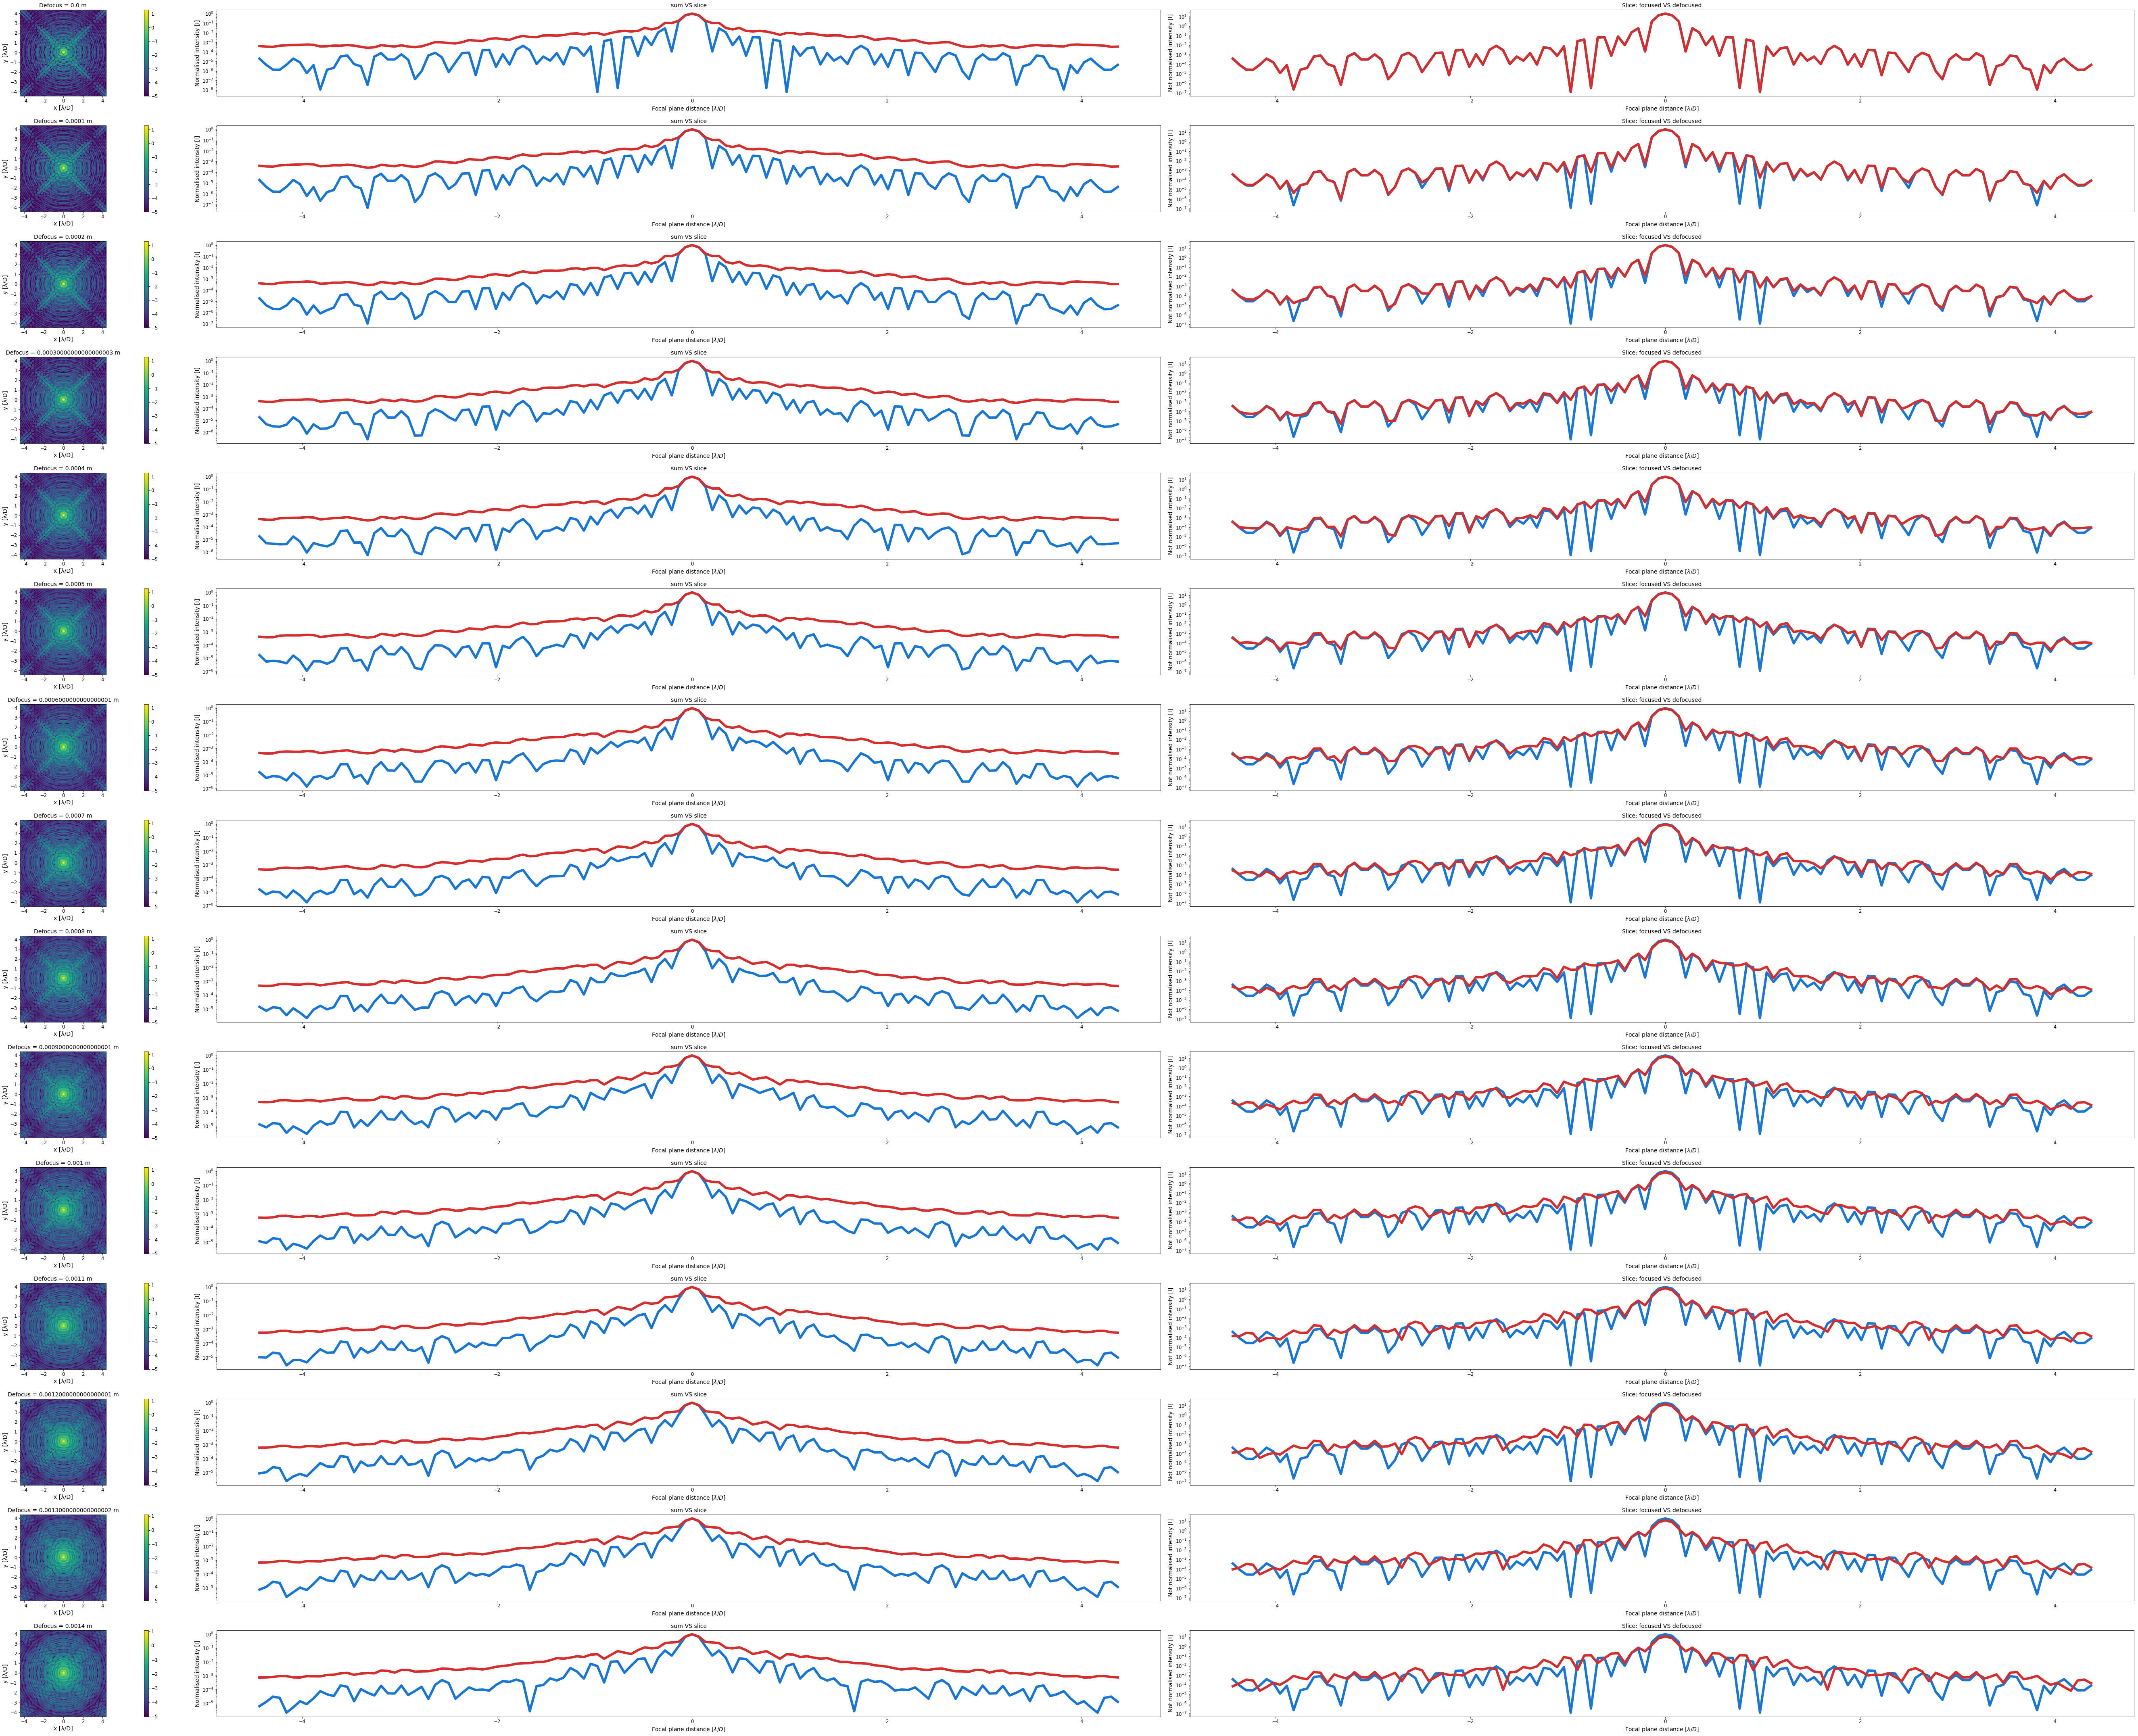

In [11]:
nbit = 15
nbsub = 3
for i in range (nbit):
    
    pupil_temp = pupil_grid.copy()
    
    shift =  0.0001*i   #0.003*10**i                  # Longitudinal displacement [m]
    nwaves = - shift * InPhase / (8*F_nb**2)
    
    defocus = hci.zernike(2,0)(pupil_temp)  
    defocus /= np.ptp(defocus)              
    defocus *= nwaves  
    
    wf2 = hci.Wavefront(tel_pupil * np.exp(1j * defocus), wvlgth)    
    focal_grid = hci.make_focal_grid(pupil_temp, sampl_focal, fov)
    prop = hci.FraunhoferPropagator(pupil_temp, focal_grid, wvlgth, 10000*focal_length)
    focal_image2 = prop.forward(wf2)
    
    int_map2 = focal_image2.intensity.shaped    
    psf_slice2 = int_map2[:,int_map2.shape[0]//2]
    psf_sum2 = int_map2.sum(0) 
        
    plt.subplot(nbit, nbsub, 1+nbsub*i)
    hci.imshow_field(np.log10(focal_image2.intensity), vmin=-5)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.xlabel('x [λ/D]')
    plt.ylabel('y [λ/D]')
    plt.title('Defocus = {} m'.format(shift))

    plt.subplot(nbit, nbsub, 2+nbsub*i)
    plt.plot(focal_grid.x.reshape(int_map.shape)[0,:], psf_slice2 / int_map2.max()     , label='slice',linewidth=6)
    plt.plot(focal_grid.x.reshape(int_map.shape)[0,:], psf_sum2 / int_map2.sum(0).max() , label='sum',linewidth=6)
    plt.xlabel('Focal plane distance [$\lambda/D$]')
    plt.ylabel('Normalised intensity [I]')
    plt.yscale('log')
    plt.title('sum VS slice')

    plt.subplot(nbit, nbsub, 3+nbsub*i)
    plt.plot(focal_grid.x.reshape(int_map.shape)[0,:], psf_slice, label='focused',linewidth=6)
    plt.plot(focal_grid.x.reshape(int_map2.shape)[0,:], psf_slice2, label='defocused',linewidth=6)
    plt.xlabel('Focal plane distance [$\lambda/D$]')
    plt.ylabel('Not normalised intensity [I]')
    plt.yscale('log')
    plt.title('Slice: focused VS defocused')

plt.tight_layout()
plt.show()